Sheet 2.3: Non-linear regression (MLP w/ PyTorch modules)
=========================================================

**Author:** Michael Franke



In this tutorial, we will fit a non-linear regression, implemented as a multi-layer perceptron.
We will see how the use of modules from PyTorch&rsquo;s neural network package \`torch.nn\` helps us implement the model efficiently.



## Packages & global parameters



We will need to import the \`torch\` package for the main functionality.
In addition to the previous sheet, In order to have a convenient, we will use PyTorch&rsquo;s \`DataLoader\` and \`Dataset\` in order to feed our training data to the model.



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## True model & training data



The &ldquo;true model&rdquo; is a constructed non-linear function $y = f(x)$.
Here is its definition and a plot to show what the &ldquo;ground truth&rdquo; looks like.



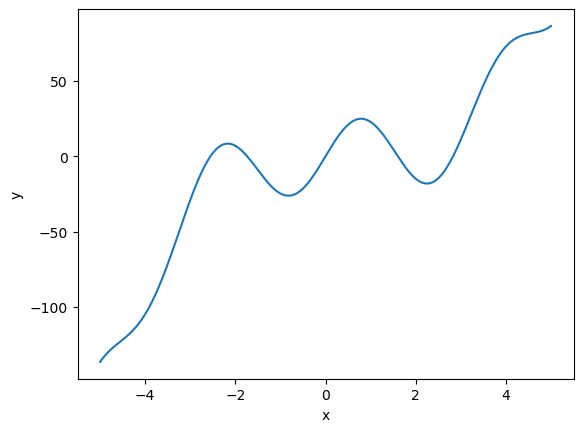

In [2]:
##################################################
## ground-truth model
##################################################

def goalFun(x):
    return(x**3 - x**2 + 25 * np.sin(2*x))

# create linear sequence (x) and apply goalFun (y)
x = np.linspace(start = -5, stop =5, num = 1000)
y = goalFun(x)

# plot the function
d = pd.DataFrame({'x' : x, 'y' : y})
sns.lineplot(data = d, x = 'x', y = 'y')
plt.show()

The training data consists of 100 pairs of  $(x,y)$ values.
Each pair is generated by first sampling an $x$ value from a uniform distribution.
For each sampled $x$, we compute the value of the target function $f(x)$ and add Gaussian noise to it.



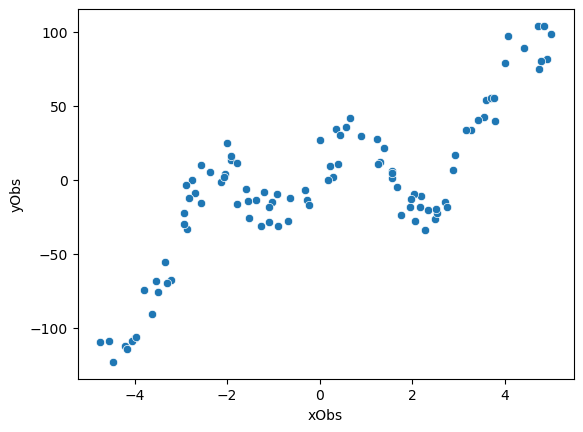

In [3]:
##################################################
## generate training data (with noise)
##################################################

nObs = 100 # number of observations

# get noise around y observations
yNormal = torch.distributions.Normal(loc=0.0, scale=10)
yNoise  = yNormal.sample([nObs])

# get observations
xObs = 10*torch.rand([nObs])-5    # uniform from [-5,5]
yObs = xObs**3 - xObs**2 + 25 * torch.sin(2*xObs) + yNoise

# plot the data
d = pd.DataFrame({'xObs' : xObs, 'yObs' : yObs})
sns.scatterplot(data = d, x = 'xObs', y = 'yObs')
plt.show()

## Defining the MLP using PyTorch&rsquo;s built-in modules



As before (sheet 4.1), our model maps a single scalar $x$ onto another scalar $y$.
We use a 3-layer MLP, each hidden layer with dimension 10:



In [4]:
##################################################
## network dimension parameters
##################################################

nInput  = 1
nHidden = 10
nOutput = 1

PyTorch defines a special-purpose class called \`nn.Module\` from which pre-defined neural networks or custom-made networks inherit the structure and basic functionality.
Below, we define our feed-forward neural network as a class extending \`nn.Module\`.
Minimally, we have to define two functions for this to work:

1.  the **initialization** function \`\_<sub>init</sub>\_\_\` which defines which variables (mostly, but not exclusively: parameters) our model has (using \`nn.Linear\` instantiates a linear layer with all the trainable parameters (weights and biases) implicitly);
2.  the **forward pass** which takes the model&rsquo;s input and computes the corresponding prediction given the current parameter values (recall the function \`singleForwardPass\` from sheet 4.1; PyTorch automatically batches the computation implicitly).

Since PyTorch allows flexibility in how to define neural network modules, we look at two variants below, one explicit and one more concise.
They should implement the exact same model and work the same way eventually.



### More explicit definition NN module



In [5]:
##################################################
## set up multi-layer perceptron w/ PyTorch
##    -- explicit version --
##################################################

class MLPexplicit(nn.Module):
    '''
    Multi-layer perceptron for non-linear regression.
    '''
    def __init__(self, nInput, nHidden, nOutput):
        super(MLPexplicit, self).__init__()
        self.nInput  = nInput
        self.nHidden = nHidden
        self.nOutput = nOutput
        self.linear1 = nn.Linear(self.nInput, self.nHidden)
        self.linear2 = nn.Linear(self.nHidden, self.nHidden)
        self.linear3 = nn.Linear(self.nHidden, self.nHidden)
        self.linear4 = nn.Linear(self.nHidden, self.nOutput)
        self.ReLU    = nn.ReLU()

    def forward(self, x):
        h1 = self.ReLU(self.linear1(x))
        h2 = self.ReLU(self.linear2(h1))
        h3 = self.ReLU(self.linear3(h2))
        output = self.linear4(h3)
        return(output)

mlpExplicit = MLPexplicit(nInput, nHidden, nOutput)

We can access the current parameter values of this model instance like so:



In [6]:
for p in mlpExplicit.parameters():
    print(p.detach().numpy().round(4))

[[ 0.7162]
 [ 0.3054]
 [ 0.5023]
 [-0.364 ]
 [-0.0214]
 [-0.5991]
 [-0.7676]
 [ 0.1173]
 [-0.9104]
 [-0.8084]]
[ 0.9982  0.0229 -0.9914 -0.1927  0.487   0.1257  0.4986 -0.7426  0.7583
 -0.2647]
[[-3.055e-01  3.130e-02  2.002e-01 -2.435e-01 -1.218e-01 -1.474e-01
  -2.876e-01  1.764e-01  2.490e-01  2.100e-03]
 [ 1.892e-01 -1.904e-01  6.000e-04 -2.335e-01  1.297e-01  4.140e-02
  -1.482e-01 -7.110e-02 -8.120e-02 -1.094e-01]
 [-1.195e-01 -2.148e-01  3.310e-02  1.756e-01 -1.996e-01 -2.229e-01
   1.505e-01 -1.807e-01 -8.000e-02  1.660e-01]
 [-8.970e-02 -8.230e-02 -1.320e-01  2.171e-01 -4.820e-02 -2.780e-02
  -4.950e-02  7.720e-02  2.308e-01 -2.290e-01]
 [-1.457e-01  1.950e-01 -1.230e-01 -1.210e-02  1.476e-01 -2.768e-01
  -2.990e-02 -2.439e-01 -1.290e-01 -1.570e-01]
 [-1.483e-01  2.570e-02  1.859e-01 -1.860e-02  8.390e-02  4.660e-02
   3.138e-01  3.088e-01  5.340e-02 -7.930e-02]
 [-1.121e-01 -5.410e-02  1.632e-01  2.295e-01  2.396e-01  2.227e-01
  -2.530e-01  1.595e-01 -2.933e-01  2.430e-02]
 

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 4.2.1: Inspect the model&rsquo;s parameters and their initial values</span></strong>
>
> 0. [Just for yourself.] Make sure that you understand what these parameters are by mapping these onto the parameters of the custom-made model from sheet 4.1. (Hint: the order of the presentation in this print-out is the order in which the components occur in the computation of the forward pass.)
>
> 1. Guess how the weights of the slope matrices are initialized (roughly). Same for the intercept vectors.



### More concise definition of NN module



Here is another, more condensed definition of the same NN model, which uses the \`nn.Sequantial\` function to neatly chain components, thus defining the model parameters and the forward pass in one swoop.



In [7]:
##################################################
## set up multi-layer perceptron w/ PyTorch
##    -- condensed version --
##################################################

class MLPcondensed(nn.Module):
    '''
    Multi-layer perceptron for non-linear regression.
    '''
    def __init__(self, nInput, nHidden, nOutput):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(nInput, nHidden),
            nn.ReLU(),
            nn.Linear(nHidden, nHidden),
            nn.ReLU(),
            nn.Linear(nHidden, nHidden),
            nn.ReLU(),
            nn.Linear(nHidden, nOutput)
        )

    def forward(self, x):
        return(self.layers(x))

mlpCondensed = MLPcondensed(nInput, nHidden, nOutput)

Here you can select which one to use in the following.



In [8]:
# which model to use from here onwards
# model = mlpExplicit
model = mlpCondensed

## Preparing the training data



Data pre-processing is a tedious job, but an integral part of machine learning.
In order to have a clean interface between data processing and modeling, we would ideally like to have a common data format to feed data into any kind of model.
That also makes sharing and reusing data sets much less painful.
For this purpose, PyTorch provides two data primitives: \`torch.utils.data.Dataset\` and \`torch.utils.data.DataLoader\`.
The class **Dataset** stores the training data (in a reusable format).
The class **DataLoader** takes a \`dataset\` object as input and returns an iterable to enable easy access to the training data.

To define a \`Dataset\` object, we have to specify two key functions:

1.  the \`\_<sub>len</sub>\_\_\` function, which tells subsequent applications how many data points there are; and
2.  the \`\_<sub>getitem</sub>\_\_\` function, which takes an index as input and outputs the data point corresponding to that index.



In [9]:
##################################################
## representing train data as a Dataset object
##################################################

class nonLinearRegressionData(Dataset):
    '''
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    '''

    def __init__(self, xObs, yObs):
        self.xObs = torch.reshape(xObs, (len(xObs), 1))
        self.yObs = torch.reshape(yObs, (len(yObs), 1))

    def __len__(self):
        return(len(self.xObs))

    def __getitem__(self, idx):
        return(xObs[idx], yObs[idx])

# instantiate Dataset object for current training data
d = nonLinearRegressionData(xObs, yObs)

# instantiate DataLoader
#    we use the 4 batches of 25 observations each (full data  has 100 observations)
#    we also shuffle the data
train_dataloader = DataLoader(d, batch_size=25 , shuffle=True)

We can test the iterable that we create, just to inspect how the data will be delivered later on:



In [10]:
for i, data in enumerate(train_dataloader, 0):
    input, target = data
    print("In: ", input)
    print("Out:", target,"\n")

In:  tensor([ 1.3828, -1.5540,  4.7408,  1.2476,  4.4112,  0.6601,  0.3932, -2.5595,
        -0.6360, -2.8668,  4.7704,  3.7725,  3.4049, -3.7961, -0.2344, -4.2058,
        -1.9234, -3.2896,  2.5081,  2.1769, -2.8967,  3.2554,  0.5577,  2.2621,
        -3.5312])
Out: tensor([  21.1964,  -14.1183,   75.1349,   10.4310,   88.7715,   41.5962,
          10.8885,   10.1166,  -12.2414,  -33.0621,   80.0496,   39.4490,
          40.6922,  -74.2503,  -16.9134, -112.5062,   15.8564,  -69.8026,
         -19.7569,  -10.9068,   -3.3683,   33.5449,   35.4243,  -34.1715,
         -68.2611]) 

In:  tensor([-2.5585e+00, -1.5232e+00,  4.9897e+00, -4.7488e-03, -1.1030e+00,
        -2.9388e+00, -1.5989e+00,  4.0657e+00, -4.0635e+00,  4.8487e+00,
         2.1542e+00,  2.5189e+00, -3.3402e+00,  2.4760e+00,  2.8843e+00,
        -4.7447e+00,  1.6738e+00,  1.6872e-01, -2.0779e+00, -2.7700e+00,
         3.6921e+00, -2.0048e+00, -1.3819e+00,  2.0519e+00,  3.4938e-01])
Out: tensor([ -15.7838,  -26.1753,   98.224

## Training the model



We can now train the model similar to how we did this before.
Note that we need to slightly reshape the input data to have the model compute the batched input correctly.



Loss after epoch  2500: 3863.520
Loss after epoch  5000: 3267.784
Loss after epoch  7500: 2239.946
Loss after epoch 10000: 1658.311
Loss after epoch 12500: 895.697
Loss after epoch 15000: 686.850
Loss after epoch 17500: 512.686
Loss after epoch 20000: 451.440
Loss after epoch 22500: 429.563
Loss after epoch 25000: 418.115
Loss after epoch 27500: 410.994
Loss after epoch 30000: 406.424
Loss after epoch 32500: 403.176
Loss after epoch 35000: 400.792
Loss after epoch 37500: 399.390
Loss after epoch 40000: 397.837
Loss after epoch 42500: 396.263
Loss after epoch 45000: 394.663
Loss after epoch 47500: 393.568
Loss after epoch 50000: 392.571
Training process has finished.


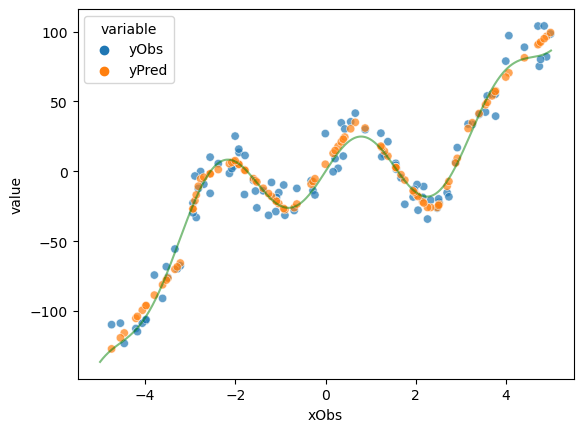

In [11]:
##################################################
## training the model
##################################################

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
nTrainSteps = 50000

# Run the training loop
for epoch in range(0, nTrainSteps):

  # Set current loss value
  current_loss = 0.0

  # Iterate over the DataLoader for training data
  for i, data in enumerate(train_dataloader, 0):
    # Get inputs
    inputs, targets = data
    # Zero the gradients
    optimizer.zero_grad()
    # Perform forward pass (make sure to supply the input in the right way)
    outputs = model(torch.reshape(inputs, (len(inputs), 1))).squeeze()
    # Compute loss
    loss = loss_function(outputs, targets)
    # Perform backward pass
    loss.backward()
    # Perform optimization
    optimizer.step()
    # Print statistics
    current_loss += loss.item()

  if (epoch + 1) % 2500 == 0:
      print('Loss after epoch %5d: %.3f' %
            (epoch + 1, current_loss))
      current_loss = 0.0

# Process is complete.
print('Training process has finished.')

yPred = np.array([model.forward(torch.tensor([o])).detach().numpy() for o in xObs]).flatten()

# plot the data
d = pd.DataFrame({'xObs' : xObs.detach().numpy(),
                  'yObs' : yObs.detach().numpy(),
                  'yPred': yPred})
dWide = pd.melt(d, id_vars = 'xObs', value_vars= ['yObs', 'yPred'])
sns.scatterplot(data = dWide, x = 'xObs', y = 'value', hue = 'variable', alpha = 0.7)
x = np.linspace(start = -5, stop =5, num = 1000)
y = goalFun(x)
plt.plot(x,y, color='g', alpha = 0.5)
plt.show()

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 4.2.2: Explore the model&rsquo;s behavior</span></strong>
>
> 0. [Just for yourself.] Make sure you understand *every line* in this last code block. Ask if anything is unclear.
>
> 1. Above we used the DataLoader to train in 4 mini-batches. Change it so that there is only one batch containing all the data. Change the \`shuffle\` parameter so that data is not shuffled. Run the model and check if you observe any notable differences. Explain what your observations. (If you do not see anything, explain why you don&rsquo;t. You might pay attention to the results of training)

